In [ ]:
# ONLY for apple slicon
! pip uninstall setuptools -y
! conda install numpy -y
! conda install pytorch torchvision torchaudio -c pytorch-nightly -y

In [ ]:
# install all required packages
! pip install -r requirements.txt

# Binäre Klassifizierung der Exzellenten Wikipedia Artikel

Die Aufgabe war es die Wikipedia Artikel mit Hilfe einer regelbasierten und einer Deep Learning Mehtode zu klassifizieren, ob diese als Exzellent bewertet wurden oder nicht. Biede Methoden sollen am Ende Evaluiert werden und miteinander verglichen werden.

In [ ]:
# imports
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# machine learning packages
from transformers import BertTokenizer
import torch
from torch import nn
from torchmetrics.classification import BinaryF1Score
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm

import os

import numpy as np
import pandas as pd

# plot diagrams and images
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# static var
CSV_FILE = "./articles_meta.csv"
SUBSET_CSV_FILE = "./data/subset/articles_meta.csv"
SUBSET_FOLDER = "./data/subset"

TRAINED_MODEL = "./trained_model.pth"

## Regelbasierte Lösung mit dem Decision Tree
Eine manuelle Lösung ist aufgrund der Komplexität und der nicht regelbasierten Auswahl der exzellenten Wikipedia Artikel durch die Community von Wikipedia. Da die Artikel von der Community gewählt werden und ausschließlich grundsätzliche Guidelines / Ideen gegeben sind, wann ein Wikipedia Arikel Exzellent sein könnte.

### Mauelle Feature Extraction und Decision Tree
Daher wurde für die Lösung dieser Aufgabe ein regelbasierter Ansatz gewählt, welcher die Regeln auf der Basis einiger Features automatisiert erlernt. Dafür wurden zunächst manuelle Features und Metadaten extrahiert, welche anschließend als Input für einem Decision Tree dienen können. Der Decision Tree erlernt auf Basis der Features in dem Training einige manuelle Regeln. Anhand dieser Regeln können anschließend die Artikel klassifiziert werden.

### Feature Extraktion

Für den regelbasierten Ansatz wurden zunächt Features extrahiert, anahnd welcher anschließend klassifiziert werden soll.
Dies erfolgte auf der Grundlage von Wikipedia angegebenen Besonderheiten von exzellenten Artiklen [(Wikipedia Artikel)](https://de.wikipedia.org/wiki/Wikipedia:Kandidaturen_von_Artikeln,_Listen_und_Portalen/Kriteriendarstellung). Zudem wurden einge Parameter ausgewählt, welche die Qualität und Quantität der Artikel abbilden. Die Feautres wurden bereits alle in dem Datennotebook extrahiert und einer CSV-Datei abgespeichert. Es wurde sich für die folgenden Features entschieden: 

* **Anzahl Wörter:** Anzahl der in einem Artikel enthalenen Wörter.
* **Anzahl Sätze:** Anzahl der in dem Artikel enthalenen Sätze.
* **Anzahl der Kapitel:** Die Anzahl der Kaptiel eines Wikipedia Artikels, unabhängig von der Kapitel Ebene.
* **Anzahl Bilder:** Die Anzahl der in den Artikel eingebundenen Bilder.
* **Anzahl Zitate:** Die Anzahl der direkten, sowie indirekten Zitate in einem Wikipedia Artikel. Viele Zitate sprechen für eine ausführliche und sehr gute Quellenarbeit und damit für einen wissenschaftlich gut belegten Artikel.
* **Anzahl zugeordnete Kategorien:** Die Anzahl der Kategorien, welche einem Artikel zugeordnet wurden.
* **Anzahl der Verlinkungen:** Die Verlinkungen zu anderen Wikipedia-Artikeln. Diese geben den Bezug zu weiteren Fachbegriffen und Themen an. Viele Verlinkungen korrelieren zumeist mit einem relevanten Thema und einer guten Qualität.
* **Wiener Sachtextformel**: Die Wiener Sachtextformel gibt die Lesbarkeit eines deutschsprachigen Textes mit den Werten 4 bis 15 an. Dies erfolgt abhängig der Satzlänge, der Anzahl von langen Wörtern(>6 Buchstaben), der Anzahl der einsilbigen Wörter sowie der Anzahl der Wörter mit drei oder mehr Silben. 

### Data-Balancing
Da der Datensatz sehr stark unausbalanciert ist, müssen zunächst in dem Datensatz die Anzahl der Exzellenten und nicht Exzellenten Artikel ausgeglichen werden. Dafür wird ein Undersamplings druchgeführt, welches die Klasse mit der geringeren Anzahl Datenpunkten als reverenz nutzt und die selbe Anzahl Artikel aus der anderen Klasse zufällig auswählt. Anschließend wird das neue Datenset in ein Trainings-, Test- und Validationdatensatz gesplietet. Der Verteilung ist (70/15/15).

In [3]:
# read meta data and filenames of original dataset
original_meta_data = pd.read_csv(CSV_FILE, header=0, index_col=0)

# split original dataset in labels and data
X = original_meta_data.drop(['is_excellent'], axis=1)
Y = original_meta_data['is_excellent']

# undersample the dataset
rus = RandomUnderSampler(random_state=42)
X, Y = rus.fit_resample(X, Y)
# print new class distribution
print('Klassenverteilung: %s \n' % Counter(Y))

# split new datset in train, test, validation
X_train, X_test_val, Y_train, Y_test_val = train_test_split(X,Y, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test_val, Y_test_val, test_size=0.5, random_state=42)
print('Verteilung der Samples:')
print('   Trainingsdatenset: %s, Testdatenset: %s, Validationdatenset: %s' % (len(Y_train), len(Y_test), len(Y_val)))

Klassenverteilung: Counter({False: 2691, True: 2691}) 

Verteilung der Samples:
   Trainingsdatenset: 3767, Testdatenset: 807, Validationdatenset: 808


### Datenanalyse (Korrelationsmatrix)
Um einen Eindruck von den erzeugten Metadaten und Features zu bekommen, wurde im Folgenden eine Korrelationsmatrix erzeugt.
Diese zeigt die Abhängigkeit der untschiedlichen Features zueinander an. Bei der selben Korrelation ist der Wert 1, bei inverser Korrelation werden negative Werte ausgegeben. Die Korrelation zu sich selbst ist immer 1.

<Axes: >

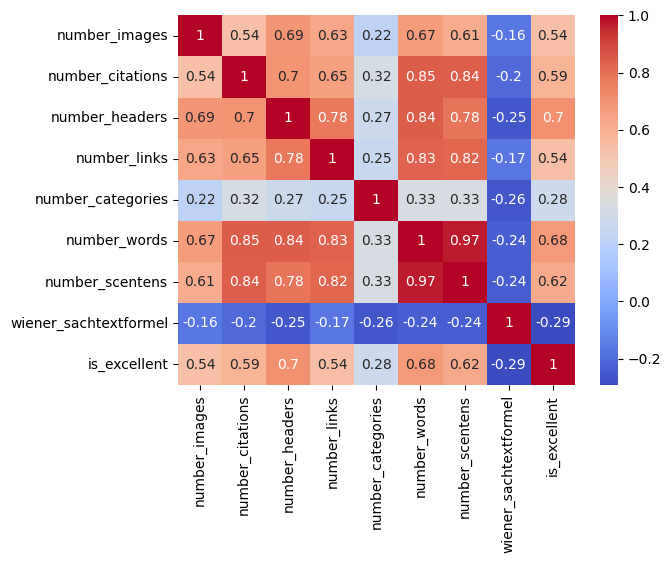

In [4]:
# generate and display correlation matrix
df_undersample = pd.concat([X,Y], axis=1)
sns.heatmap(df_undersample.corr(), annot=True, cmap='coolwarm')

Bei der Coorelationsmatrix ist auffällig, dass die Anzahl der zugeordneten Kategorien mit keiner weiteren Variable stark korreliert. Bie Wiener Sachtextformel hat immer eine negative Korrelation. Das liegt vermutlich daran, dass die Werte für einfache Texte niedrig sind und bei höherer Komplexität ansteigen. Die restlichen Variablen, korrelieren deutlich stärker miteinander. Das ist vermutlich auf die Artikellänge und somit erhöhter Anzahl Zitate, Bilder etc. zurückzuführen. Eine besonders starke Korrelation ist zwischen der Anzahl der Wörter und Sätze zu sehen, was trivial zu erklären ist. Daran kann erkannt werden, dass die Korrelationsmatrix valide ist.
Das Label, also ob ein Artikel Exzellent ist, korreliert am stärksten mit der Anzahl der Titel / Abschnitte in einem Artikel. Auch die Länge der Artikel (Wörter/Sätze) hat ein großen Einfluss. Die Anzahl der Kategorien und die Lesbarkeit hingegen, haben einen geringeren Einfluss.

### Descision Tree

Im Folgenden wird ein Decision Tree erstellt. Diese sind in Baumform dargestellte Entscheidungsregeln, dessen Äste immer am Ende eine der beiden Kategorien zuordnen. Die Regeln des Decision Tree werden automatisiert erlernt. 

#### Training des Decision Tree
Um den perfekten Decision Tree zu erzeugen muss eine Hyperparameter-Optimierung durchgeführt werden. Dabei werden unteranderem die Maximale Länge der Äste, die Funktion zur Bestimmung der besten Entscheidungsregel und die minimale Anzal an Artikel aus dem Trainingsset für einen neuen Split getestet und optimiert. Die Entscheidung, ob eine Hyperparameterwahl besser ist als eine andere erfolgt auf der Basis der Accuracy des Validation Datensatzes. Das beste Modell wird gespiechert und kann anschließend zum Vorhersagen genutzt werden. 

In [5]:
best_acc = 0
best_model = None

# fit decsision tree with hyperparameter optimization (grid search)
# criterion function to choose the best spilt
for criterion in ['gini','entropy']:
    # max number knots per branch of the decision tree
    for max_depth in [2,3,5,7,10,15]:
        # min samples per leaf / knot
        for min_samples_leaf in [1,2,3,5,10,15]:
            # min samples need for a new split
            for min_samples_split in [2,3,5,8,10,12,18,20]:
                # print current hyperparameter configuration
                print('-params- criterion: %s, max_depth: %s, min_samples_leaf: %s, min_samples_split: %s' % (criterion, max_depth, min_samples_leaf, min_samples_split))

                # initalize decision tree with hyperparameters
                decision_tree = tree.DecisionTreeClassifier(
                    criterion=criterion, 
                    max_depth=max_depth, 
                    min_samples_leaf=min_samples_leaf, 
                    min_samples_split=min_samples_split, 
                    random_state=42)
                
                # fit decision tree
                decision_tree = decision_tree.fit(X_train,Y_train)

                # calculate accuracy and check if it is the best model
                y_pred = decision_tree.predict(X_val)
                
                # check if new model is better than the best before
                if(metrics.accuracy_score(Y_val, y_pred) > best_acc):
                    # save new best model and acc
                    best_model = decision_tree
                    best_acc = metrics.accuracy_score(Y_val, y_pred)
                    print('new best model with val-acc: %s' % best_acc)

# Model Test-Accuracy
y_pred = best_model.predict(X_test)
print("Best Model Test-Accuracy:", metrics.accuracy_score(Y_test, y_pred))


-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 2
new best model with val-acc: 0.9665841584158416
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 3
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 5
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 8
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 10
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 12
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 18
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 20
-params- criterion: gini, max_depth: 2, min_samples_leaf: 2, min_samples_split: 2
-params- criterion: gini, max_depth: 2, min_samples_leaf: 2, min_samples_split: 3
-params- criterion: gini, max_depth: 2, min_samples_leaf: 2, min_samples_split: 5
-params- criterion: gini, max_depth: 2, min_sa

Der Beste Decision Tree hat eine Accuracy auf dem Validation-Datensatz von 97,2%. <br>
Die Hyperparamter sind:
* criterion: entropy
* max_depth: 3
* min_samples_leaf: 1
* min_samples_split: 2

#### Visualisierug der erlernten Regeln
Um ein besseres Versändnis zu bekommen, erzeugen wir ein Bild von dem erzeugten Entscheidungsbaum. Aus diesen können alle Regeln abgeleitet werden und theoretisch auch eine manuelle zuordnung neuer Artikel vorgenommen werden. 

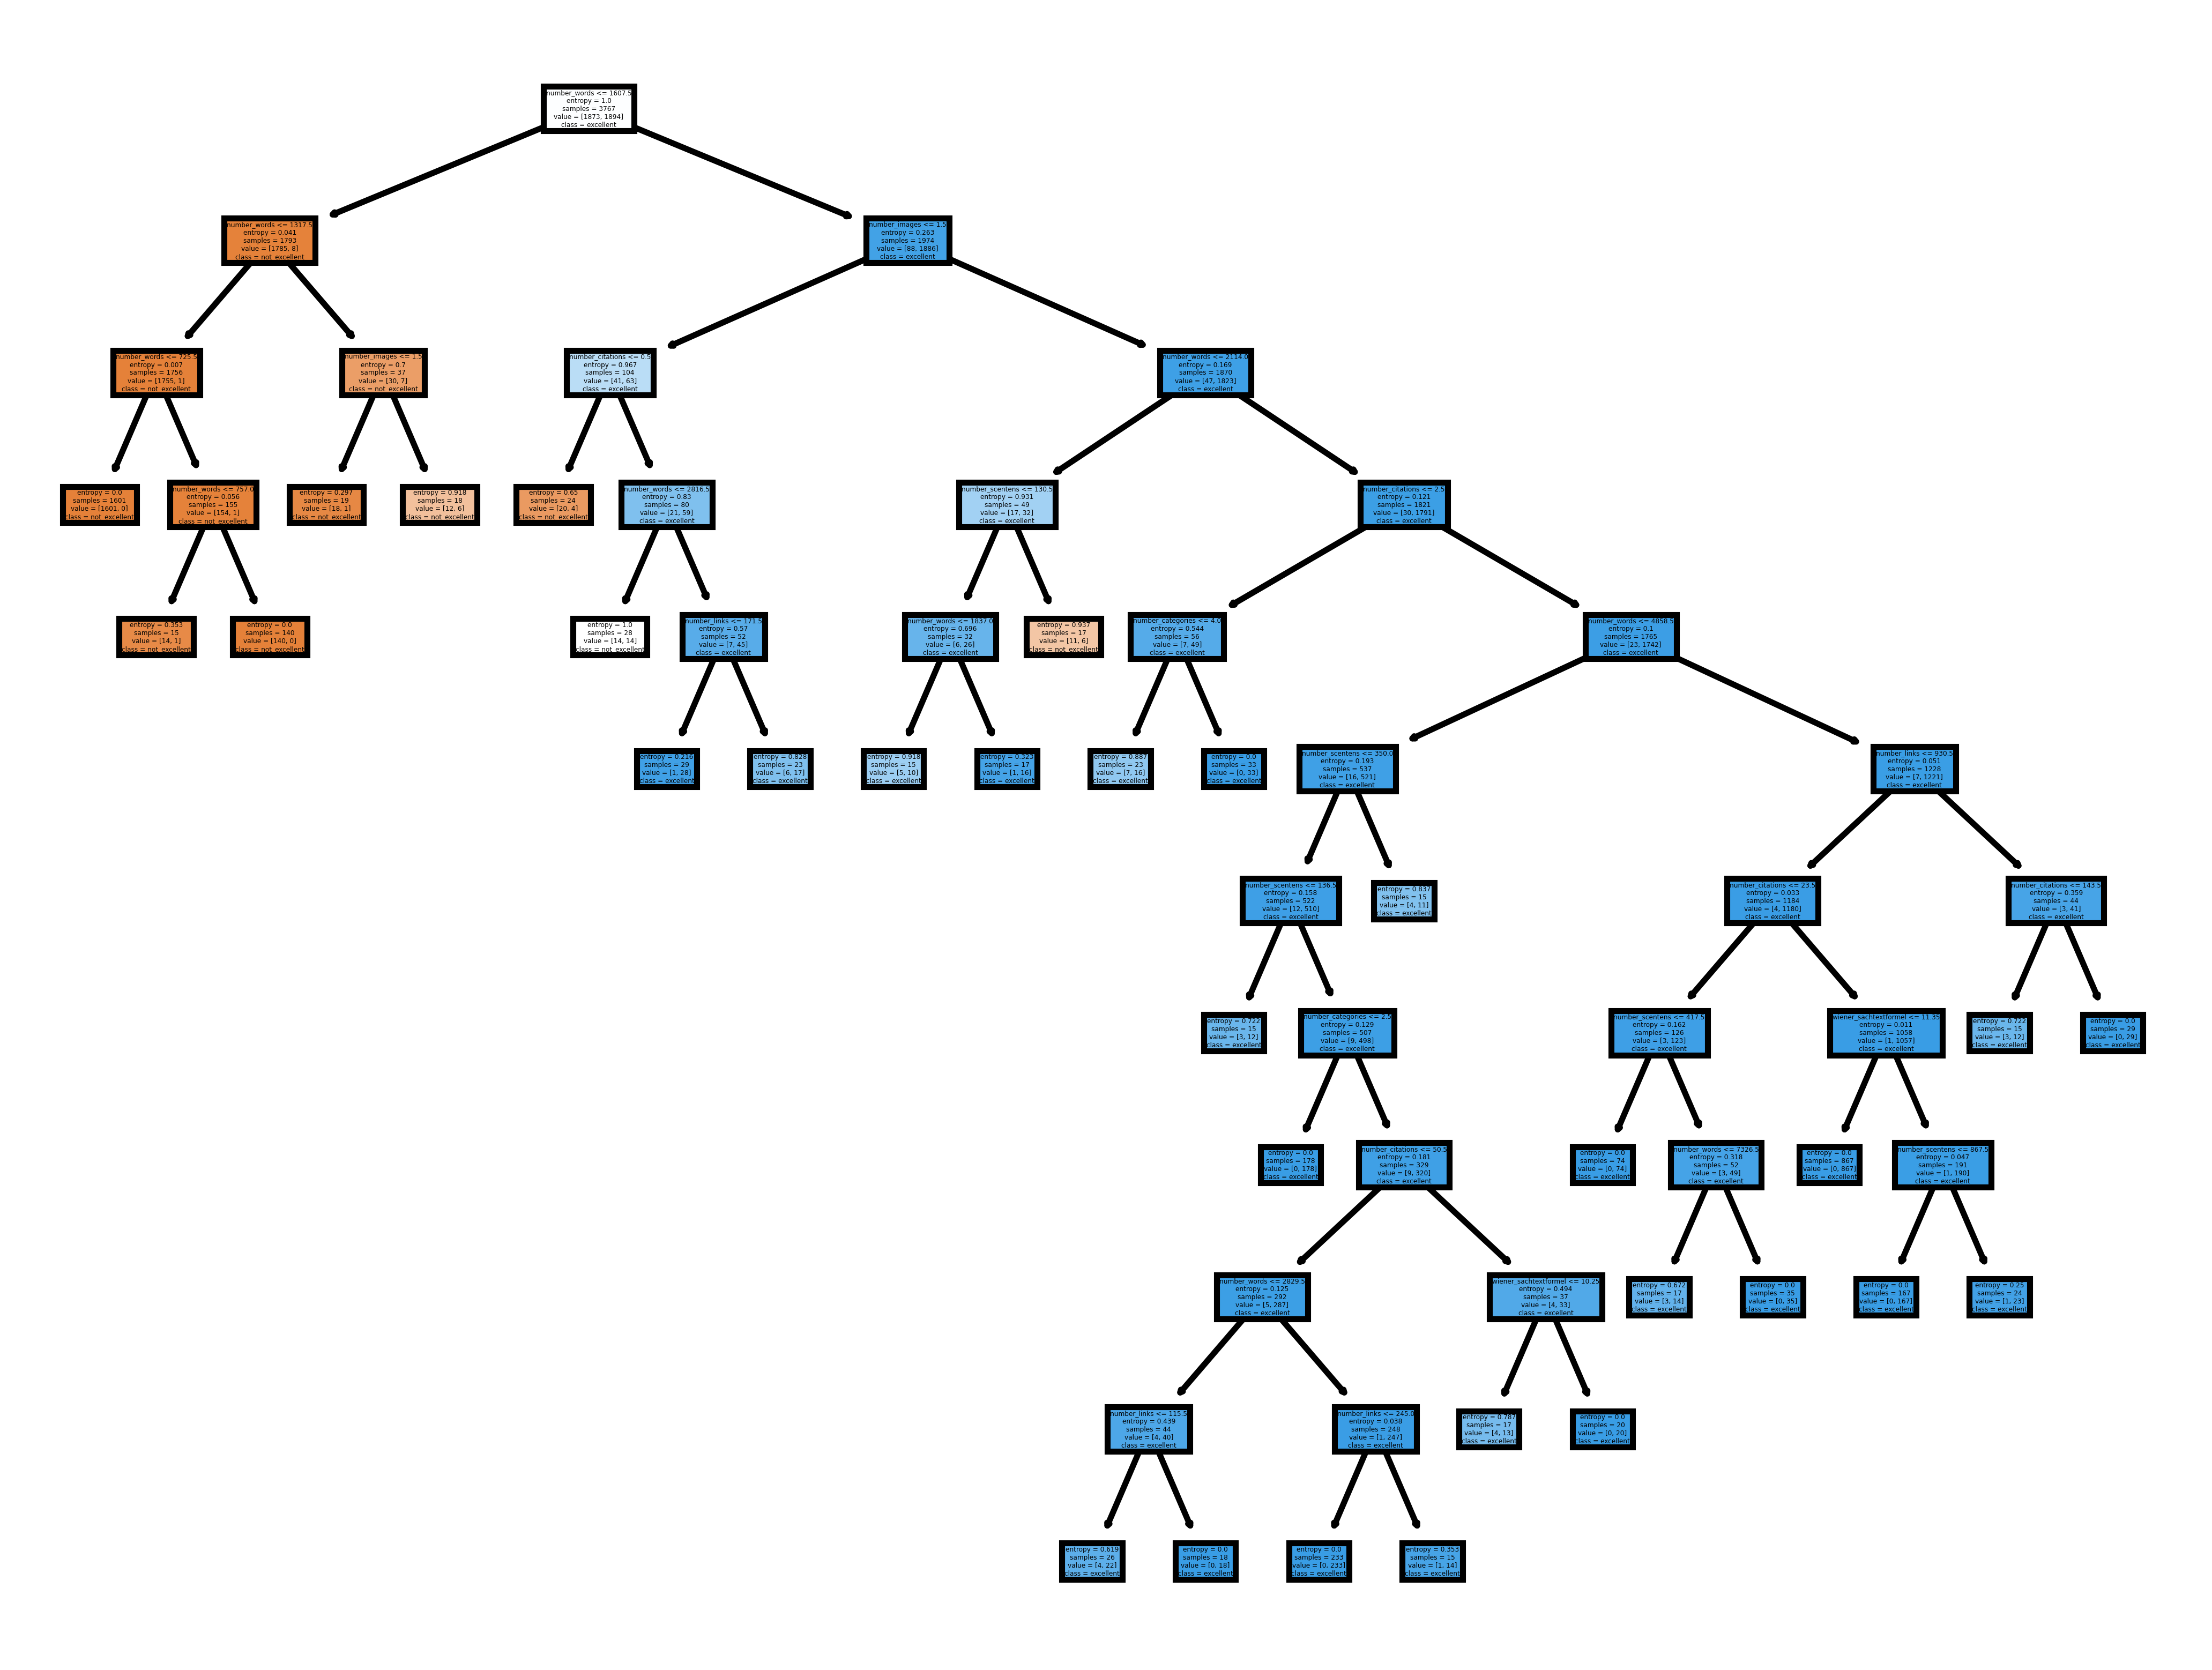

In [7]:
# generate plot with high resolution
fig, axes = plt.subplots(dpi=800)

# plot the tree
tree.plot_tree(decision_tree,
           feature_names = X.columns.values.tolist(), 
           class_names=['not_excellent', 'excellent'],
           filled = True)
# save image as file
fig.savefig("./explanation/tree_viz.png")

#### Evaluation
Im Folgenden wird eine Evaluation des Decision Trees durchgeführt. Es wurde sich für drei Metriken entscheiden, anhand welcher die Performance sehr gut abgeleitet werden kann. 

* **Accuracy:** Die Genauigkeit eines Algorithmus. Setzt die Anzahl der richtigen Vorhersagen in Verhältnis der Anzal der Test-Beispiele.
* **F1-Score:** Der F1-Score zeigt die Balance zwischen Precision und Recall auf. Mit dem F1-Score ist eine ausgewogenere Bewertung unter der Berücksichtigung der gleichmäßigkeit der Klassen.
* **Konfusionsmatrix (Wahrheitsmatrix):** Eine Visuelle Darstellung der Ergebnisse für ein besseres Versändnis der Performance und der zuordnung der Fehler. Die Spalten geben die Vorhergesagten Werte an und die Zeilen die eigentlich korrekten Label.

Test-Accuracy: 0.975
F1-Score: 0.976


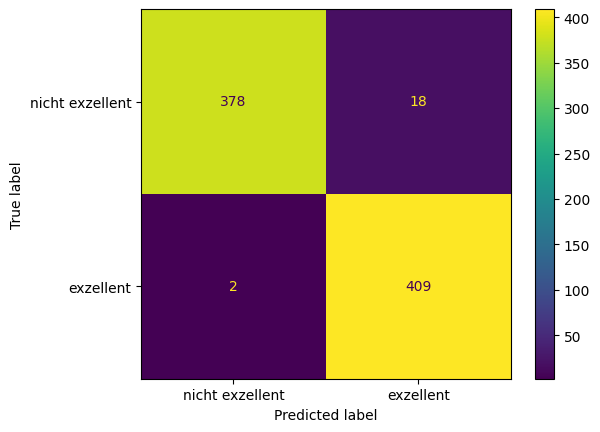

In [35]:

y_pred = best_model.predict(X_test)

# calculate accuracy
accuracy = metrics.accuracy_score(Y_test, y_pred)
print('Test-Accuracy: %.3f' % accuracy)

# calculate f1 score
f1 = metrics.f1_score(Y_test, y_pred, labels=best_model.classes_, average='binary', sample_weight=None)
print('F1-Score: %.3f' % f1)

# generate confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred, labels=[False, True])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['nicht exzellent', 'exzellent'])
disp.plot()

Der Decision Tree hat nur 20 Artikel aus dem zuvor noch nie gesehenen Test-Datensatz falsch erkannt. Das entspricht einer Accuracy von über 97% und einem nahezu identischen F1-Score. Diese Ergebnisse sind bei einer Anzahl von über 800 Arikel sehr bemerkenswert! Dennoch kann ein kleiner "Überhang" zu False Positive (fälschlicher Weise als Exzellent erkannte Artikel) aus der Konfusionsmatrix erkannt werden.

## Deep Learning Lösung
### BERT Classifier
Grundstrucktur und einige Code-Teile entommen aus: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

Das BERT (Bidirectional Encoder Representations from Transformers) Modell ist ein modernes, Deep Learning Modell, das auf der Transformer-Architektur basiert und für die Verarbeitung natürlicher Sprache entwickelt wurde. BERT wurde von Google entwickelt und ist bekannt für seine Fähigkeit, kontextabhängige Wortrepräsentationen zu erlernen, indem es sowohl die vorherigen als auch die folgenden Wörter in einem Satz berücksichtigt. BERT kann bereits vortrainiert heruntergeladen werden und muss nur noch gefinetuned werden. Auf Basis des Outputs von BERT wird anschließend mithilfe von weiteren Fully-Connected Layern eine Binäre Klassifizierung durchgeführt. Das verwenden eines Deep Learning Modells benötigt deutlich mehr Rechenleistung und Zeit zur Vorhersage.

#### Apple Silicon CPU / GPU
Check ob Apple Silicon Chips genutzt werden können. Der Trainings- und Evaluierungscode kann sowohl auf GPU, CPU als auch auf den MPS von Apple Silicon ausgeführt werden.

In [4]:
# test if m1 chip is used
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


#### Auswahl der Hyperparameter und Modelle
Im folgenden werden die Hyperparameter für das Training gesetzt. Es wurde sich unteranderem für bereits auf deutschen Texten vortrainierte Modelle als Basis entschieden. Die Länge der Text Sequenzen wurde auf 512 Wörter beschränkt. Die beste Anzahl der Epochen hat sich bei einigen Versuchen auf 10 eingependelt. Die Learningrate wurde ebenfalls getestet und bringt ein gutes Mittelmaß zwischen schneller Anpassung der Gewichte und vermeiden eines Overfittings.

In [5]:
# random seed for 
np.random.seed(112)

## tokenizer config ##
# pretrained tokenizer model
PRETRAINED_TOKENIZER_MODEL_NAME = 'bert-base-german-cased' # 'bert-base-german-cased' for german or 'bert-base-multilingual-cased'
# size of output tensor
MAX_SEQUENZ_LENGTH = 512
PADDING = 'max_length'
TURNCATION = True
RETURN_TRNSORS = 'pt'

## training config ##
# name of pretrained model
PRETRAINED_MODEL_NAME = 'bert-base-german-cased' # 'bert-base-multilingual-cased' # Best model for text in other language than english
# number of training epochs
EPOCHS = 10
# learning rate
LR = 1e-6

#### Tokenizer / aufbereitung der Artikel
Machine Learning Modelle können schlecht mit Texten arbeiten. Da ein Neuronales Netz ebenfalls nur aus einer Verkettung sich selber anpassenden Formeln besteht, müssen diese zwangsweise mit Numerischen Werten bedient werden. Daher wird ein Tokeniser eingesetzt, welcher jedem Wort eine eindeutige ID zuordnet. Diese IDs wurden bereits in einem anderen ML-Modell erlernt und in dieser Aufgabe nicht weiter angepasst, sondern direkt der Output des vortrainierten Modelles genutzt und in das Klassifizierungsmodell gegeben. Zum besseren Verständnis wurde ein Beispiel in den Code integrirert. 

In [6]:
# tokenzier for preprocessing the text
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_TOKENIZER_MODEL_NAME)
# output labels
labels = {'not_excellent':0,
          'excellent':1}


# demo of tokenizer function
example_text = ['Wikipedia', 'The Germann Wikipedia dump has a Size of 26GB']
bert_input = tokenizer(example_text,padding=PADDING, max_length = MAX_SEQUENZ_LENGTH, 
                       truncation=TURNCATION, return_tensors=RETURN_TRNSORS)

# tokenizer output => array[2]:
# 0. input_ids: id representation of each token
print(bert_input['input_ids'])
# 1. token_type_ids: binary mask that identifies in which sequence a token belongs
print(bert_input['token_type_ids'])
# 3. attention_mask: binary mask that identifies whether a token is a real word or just padding
print(bert_input['attention_mask'])

tensor([[    3, 15815, 16640,  ...,     0,     0,     0],
        [    3,  1233,  6594,  ...,     0,     0,     0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


#### Datenset Klasse
Die Datenset klasse definiert die Datenpunkte und bringt den Tokenizer in die "Piepeline" des BERT-Klassifizierungsmodells. Zudem kann mithilfe dieser Klasse die Daten in kleinere Batches für das Training unterteilt werden. 

In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df) -> None:

        self.labels = [labels[label] for label in df['Label']]
        self.texts = [tokenizer(text, padding=PADDING, max_length = MAX_SEQUENZ_LENGTH, 
                       truncation=TURNCATION, return_tensors=RETURN_TRNSORS) for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Im nachfolgenden Code werden die Datensets erzeugt. Dafür werden die bereits beim Decision Tree unterteilten datensetz genutzt und mit den Texten der Artikel ergänzt. Das nutzen des selben Splits ermöglicht eine Vergleichbarkeit der Evaluierungsergebnisse beider Algorithmen.

<span style="color:red"> Den nachfolgenden Code-Block nur ausführen, wenn das Datenaufbereitungs-Notebook ausgeführt wurde. Anderenfalls können die Daten aus dem Subset bei der Evaluation geladen werden.</span>

In [8]:
# generate df with text and label based on the split of decision tree
# iter train, test and val dataset
for idx, (x_dataset,y_dataset) in enumerate([(X_train,Y_train),(X_val, Y_val),(X_test,Y_test)]):
    # concat x and y
    dataset = pd.concat([x_dataset,y_dataset], axis=1)

    # empts lists
    list_text = []
    list_labels = []

    # iter all articles in dataset
    for article_id, article in dataset.iterrows():
        # get folder name based on label
        ordner = './data/exzellent' if article['is_excellent'] else './data/not_exzellent'
        # merge filename
        filename = str(article_id) + '.txt'
        # join filepath
        filepath = os.path.join(ordner, filename)
            
        # open file and read text
        with open(filepath, 'r') as f:
            text = f.read()
            f.close()

        # append text and label to lists
        list_text.append(text)
        lbl = 'excellent' if article['is_excellent'] else 'not_excellent'
        list_labels.append(lbl)
    
    # generate df based on dataset and list
    if idx == 0:
        df_train = pd.DataFrame({'Text': list_text, 'Label': list_labels})
    elif idx == 1:
        df_val = pd.DataFrame({'Text': list_text, 'Label': list_labels})
    else:
        df_test = pd.DataFrame({'Text': list_text, 'Label': list_labels})

print('size of dataset - train: %s, val: %s, test: %s' % (len(df_train),len(df_val), len(df_test)))

size of dataset - train: 3767, val: 808, test: 807


#### Model class
Erstellen des Machine Learning Modells, auf Basis des BERT-Modells von Google und eines weiteren Linearen Layers. Definieren aller Layer und des Aufbaus des ML-Modells.

In [9]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        
        # define Layers
        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    # forward network for classification
    def forward(self, input_id, mask):
        # define forward function and the order of the layers
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

#### Training Loop
In der Trainings-Schleife wird das Klassifizierungs-Modell trainiert. Hier wird für jede Epoche, für alle Trainingsbatches, der Loss berechnet und damit die Gewichte des Neuronalen Netzes angepasst. Das Training wird dabei mit allen zuvor definierten Hyperparametern durchgeführt. Anschließend werden die Gewichte des Modelles in einer Datei gespeichert, welche jederzeit wieder geladen werden können. Beachten Sie, dass das Training einige Stunden in Anspruch nimmt. 

<span style="color:red">Kann **nicht ausgeführt** werden, wenn das Datenaufbereitungs-Notebook nicht ausgeführt wurde! </span>

In [21]:
def train(model, train_data, val_data, learning_rate, epochs):

    # generate train and validation dataset
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    # use best device for training in the following sequenz: mps, gpu, cpu
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")

    # define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    # send model and Loss function to device
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        model = model.to(device)
        criterion = criterion.to(device)
    elif use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    # epoch loop
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            # trainingsloop 
            for train_input, train_label in tqdm(train_dataloader):

                # send data to device
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                # forwardpropagation
                output = model(input_id, mask)

                # calculate loss
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                # calculate accuracy 
                _, pred = torch.max(output,1)
                acc = (pred == train_label).sum().item()
                total_acc_train += acc

                # backprobagation
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                # validation loop
                for val_input, val_label in val_dataloader:

                    # send data to used device
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    # predict outputs of batch
                    output = model(input_id, mask)

                    # calclulate loss
                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    # calculate val acc
                    _, pred = torch.max(output, 1)
                    acc = (pred == val_label).sum().item()
                    total_acc_val += acc
            
            # print training progress
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
    return model

In [27]:
# train the Bert classifier modell with wikipedia data
model = BertClassifier()
model = train(model, df_train, df_val, LR, EPOCHS)

# save the trained model
torch.save(model.state_dict(), TRAINED_MODEL)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/1884 [00:00<?, ?it/s]/Users/janmoormann/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated,

Epochs: 1 | Train Loss:  0.258                 | Train Accuracy:  0.836                 | Val Loss:  0.132                 | Val Accuracy:  0.918


100%|██████████| 1884/1884 [12:03<00:00,  2.60it/s]


Epochs: 2 | Train Loss:  0.091                 | Train Accuracy:  0.944                 | Val Loss:  0.124                 | Val Accuracy:  0.908


100%|██████████| 1884/1884 [11:48<00:00,  2.66it/s]


Epochs: 3 | Train Loss:  0.061                 | Train Accuracy:  0.962                 | Val Loss:  0.101                 | Val Accuracy:  0.936


100%|██████████| 1884/1884 [11:50<00:00,  2.65it/s]


Epochs: 4 | Train Loss:  0.039                 | Train Accuracy:  0.976                 | Val Loss:  0.097                 | Val Accuracy:  0.937


100%|██████████| 1884/1884 [11:46<00:00,  2.67it/s]


Epochs: 5 | Train Loss:  0.021                 | Train Accuracy:  0.988                 | Val Loss:  0.117                 | Val Accuracy:  0.932


100%|██████████| 1884/1884 [11:44<00:00,  2.67it/s]


Epochs: 6 | Train Loss:  0.016                 | Train Accuracy:  0.989                 | Val Loss:  0.102                 | Val Accuracy:  0.937


100%|██████████| 1884/1884 [11:46<00:00,  2.67it/s]


Epochs: 7 | Train Loss:  0.008                 | Train Accuracy:  0.997                 | Val Loss:  0.138                 | Val Accuracy:  0.937


100%|██████████| 1884/1884 [11:46<00:00,  2.67it/s]


Epochs: 8 | Train Loss:  0.005                 | Train Accuracy:  0.998                 | Val Loss:  0.125                 | Val Accuracy:  0.947


100%|██████████| 1884/1884 [11:53<00:00,  2.64it/s]


Epochs: 9 | Train Loss:  0.006                 | Train Accuracy:  0.997                 | Val Loss:  0.123                 | Val Accuracy:  0.952


100%|██████████| 1884/1884 [11:53<00:00,  2.64it/s]


Epochs: 10 | Train Loss:  0.002                 | Train Accuracy:  0.999                 | Val Loss:  0.137                 | Val Accuracy:  0.947


### Laden des trainierten Modells
Alternativ kann auch ein bereits durch uns traniertes Modell geladen werden. Ein training und eine vollständige Datenaufbereitung ist somit nicht mehr notwendig.
Dafür muss der nachfolgende Code-Block ausgeführt werden. Danach kann direkt mit der Evaluierung fortgesetzt werden. 

In [78]:
model = BertClassifier()
model.load_state_dict(torch.load('trained_model.pth'))

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

#### Evaluierung / Test des Bert Modells
Im Folgenden Teil wird die Evaluierung des BERT-Modells durchgeführt. Dafür werden, wie für den Decision Tree auch, die Accuracy und der F1 Score berechnet sowie eine Konfusionsmatrix erstellt. Die Evaluierung kann mit dem Subset (Equivalent zu dem Testset) durchgeführt werden. 

<span style="color:red">Laden der Testdaten nur ausführen, wenn diese **nicht** bereits vor dem Training geladen wurden!</span>

In [24]:
# generate testset from subset
# load filenames from meta csv
dataset = pd.read_csv(SUBSET_CSV_FILE, header=0, index_col=0)

# empts lists
list_text = []
list_labels = []

# iter all articles in dataset
for article_id, article in dataset.iterrows():
    # get folder name based on label
    ordner = SUBSET_FOLDER + ('/exzellent' if article['is_excellent'] else '/not_exzellent')
    # merge filename
    filename = str(article_id) + '.txt'
    # join filepath
    filepath = os.path.join(ordner, filename)
        
    # open file and read text
    with open(filepath, 'r') as f:
        text = f.read()
        f.close()

    # append text and label to lists
    list_text.append(text)
    lbl = 'excellent' if article['is_excellent'] else 'not_excellent'
    list_labels.append(lbl)

# define test df
df_test = pd.DataFrame({'Text': list_text, 'Label': list_labels})

print('size of test dataset: %s' % len(df_test))

size of test dataset: 807


In [28]:
def evaluate(model, test_data):

    # define test dataset
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    # find best device
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    
    # send model to device
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        model = model.to(device)
    elif use_cuda:
        model = model.cuda()

    total_acc_test = 0
    pred = []
    target = []

    with torch.no_grad():
        # loop test badges
        for test_input, test_label in test_dataloader:

            # send data to device
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            # predict the batch with trained model
            output = model(input_id, mask)
            
            # calculate accuracy
            _, predicted = torch.max(output, 1)
            acc = (predicted == test_label).sum().item()
            total_acc_test += acc
            
            # append predictions to list
            temp_true=test_label.cpu().numpy()
            temp_pred=predicted.cpu().numpy()
            pred+=temp_true.tolist()
            target+=temp_pred.tolist()
    
    print(f'Test-Accuracy: {total_acc_test / len(test_data): .3f}')

    # return predicitons and targets
    return pred, target

generate testset predictions
Test-Accuracy:  0.943
F1-Score: 0.944


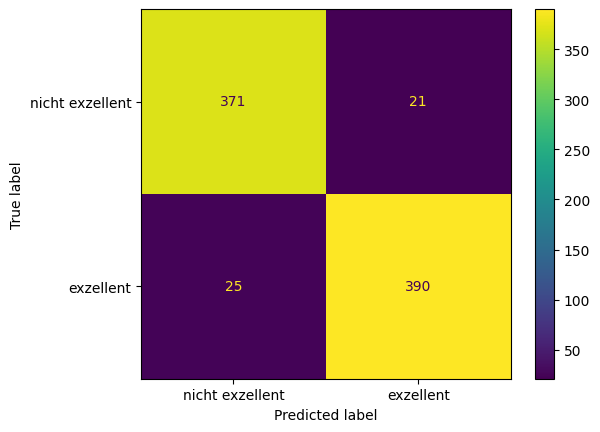

In [30]:
# run evaluation
print('generate testset predictions')
pred, target = evaluate(model, df_test)

# generate list of bools
target_bool = list(map(bool,target))
pred_bool = list(map(bool,pred))

# calculate F1-Score
f1 = metrics.f1_score(target_bool, pred_bool, labels=[False, True], average='binary', sample_weight=None)
print('F1-Score: %.3f' % f1)

# generate confusion matrix
cm = metrics.confusion_matrix(target_bool, pred_bool, labels=[False, True])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['nicht exzellent', 'exzellent'])
disp.plot()

Auch bei dem BERT-Klassifizierungsmodell konnten sehr gute Ergebnisse erzielt werden. Dennoch ist die Accuracy mit 94% minimal schlechter, als die des Decission Trees. Bei der Bertrachtung der Konfusionsmatrix fällt dafür aus, dass die Falsch-Klassifizierung der Arikel deutlich ausgeglichener ist. Es werden insgesamt nur 46 Artikel falsch erkannt. 

## Ergebnisse und Zusammenfassung

Es wurden zwei grundverschiedene Ansätze entwickelt, implementiert, trainiert und anschließend getestet. Dafür wurde ein Wikipedia Dump mit über 26 Gb Text genutzt. Dieser wurde heruntergebrochen auf einzelne Artikel, Meta Daten und Feautres erzeugt, um anschließend einen ausbalancierten Datensatz zu erzeugen. Dieser Datensatz wurde nach dem State of the Art Prinzip in drei Datensets gesplitet, um ein ordentliches Training und Testing zu ermöglichen. Die erziehlten Ergebnisse von beiden Algoithmen sind hervorragend und sehr beeindruckend. Die besten Ergebnisse mit einer Genauigkeit von über **97,5 %**  hat der Decision Tree erzeugt. Das Deep Learning Modell hingegen war minimal schlechter mit einer Genauigkeit von **94,3 %**. Beide Algoithmen können daher ohne bedenken für eine vorhersage genutzt werden. Jedoch sollte die Regelbasierte Lösung dem BERT-Klassifizierungsmodell vorgezogen werden, da dieses nicht nur bessere Ergebnisse erziehlt hat, sondern auch immens weniger Rechenleistung und Verarbeitungszeit benötigt. 